In [2]:
import sys
#If using Google Colab:
#sys.path.append("/content/drive/MyDrive/Colab Notebooks/CompVis/hw6")
import hw6_datasets_2022 as datasets
from hw6_model_2022 import RCNN
import os
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2

In [3]:
ROOT_google = "/content/drive/MyDrive/Colab Notebooks/CompVis/hw6"
ROOT_aimos = "."
TRAIN_FILES_google, TRAIN_JSON_google = 'small/train', 'small/train.json'
VALID_FILES_google, VALID_JSON_google = 'small/valid', 'small/valid.json'
TRAIN_FILES_aimos, TRAIN_JSON_aimos = 'drive-data/train', 'drive-data/train.json'
VALID_FILES_aimos, VALID_JSON_aimos = 'drive-data/valid', 'drive-data/valid.json'

training_dataset = datasets.HW6Dataset(os.path.join(ROOT_aimos, TRAIN_FILES_aimos), os.path.join(ROOT_aimos, TRAIN_JSON_aimos))
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=6, pin_memory=True)
validation_dataset = datasets.HW6Dataset(os.path.join(ROOT_aimos, VALID_FILES_aimos), os.path.join(ROOT_aimos, VALID_JSON_aimos))
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, num_workers=6, pin_memory=True)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:
def area(rect):
    h = rect[3] - rect[1]
    w = rect[2] - rect[0]
    return h * w

#My personal helper function
#Checking to see if the coordinate is in the bounding box
def coordinate_in_box(rect, coordinates):
    return (rect[0] <= coordinates[0] and rect[2] >= coordinates[0]) and (rect[1] <= coordinates[1] and rect[3] >= coordinates[1])


def iou(rect1, rect2):
    """
    Input: two rectangles
    Output: IOU value, which should be 0 if the rectangles do not overlap.
    """
    #Intersection area / union area
    rect1_area, rect2_area = area(rect1), area(rect2)
    top_x, top_y = max(rect1[0], rect2[0]), max(rect1[1], rect2[1])
    bottom_x, bottom_y = min(rect1[2], rect2[2]), min(rect1[3], rect2[3])
    
    #If the top left and bottom right intersection coordinates are not in the rectangles, there is no intersection
    #Therefore IOU is 0
    if not (coordinate_in_box(rect1, (top_x, top_y)) and coordinate_in_box(rect1, (bottom_x, bottom_y)) \
        and coordinate_in_box(rect2, (top_x, top_y)) and coordinate_in_box(rect2, (bottom_x, bottom_y))):
            return 0
            
    intersection_area = np.abs((bottom_x - top_x) * (bottom_y - top_y))
    union_area = np.abs(rect1_area + rect2_area - intersection_area)
    return intersection_area / union_area

In [10]:
def regression_loss_function(pred_labels, pred_bboxes, gt_boxes, gt_labels):
    #Use the ground truth labels to determine which one of the C bounding boxes will contribute to the loss
    detections_mask = (torch.argmax(pred_labels, dim=1) == gt_labels) & (gt_labels != 0)
    correct_detection_labels = gt_labels[detections_mask]
    #Only compare the bounding boxes for predicted classes that match the ground truth for actual detections
    pred_bboxes_rows = pred_bboxes[detections_mask,:]#4C predicted detection bounding boxes
    class_indices = torch.transpose(torch.cat(((gt_labels[detections_mask] * 4 - 4).view(1,-1), \
                                             (gt_labels[detections_mask] * 4 - 3).view(1,-1), \
                                             (gt_labels[detections_mask] * 4 - 2).view(1,-1), \
                                             (gt_labels[detections_mask] * 4 - 1).view(1,-1)), dim=0), 0,1)
    detection_boxes = pred_bboxes_rows.gather(1, class_indices)
    #Output the average loss for the batch
    criterion = nn.MSELoss()
    loss = criterion(detection_boxes, gt_boxes[detections_mask,:]) if detection_boxes.size()[0] > 0 else torch.Tensor([0]).to("cuda")
    return loss, detection_boxes, gt_boxes[detections_mask,:]

In [11]:
def train(training_dataloader, model, class_loss_fn, bounding_box_loss_fn, optimizer, hyper_lambda=1, confusion_matrix_bool=False):
    size = len(training_dataloader.dataset)
    batches = len(training_dataloader)
    model.train()
    train_loss_combined = 0
    train_loss1 = 0
    train_loss2 = 0
    class_predictions = []
    gt_classes = []
    for batch, (candidate_region, gt_bbox, gt_label) in enumerate(training_dataloader):
        candidate_region, gt_bbox, gt_label = candidate_region.to(device).float(), gt_bbox.to(device).float()\
                                              ,gt_label.to(device).to(torch.int64)
        # Compute total prediction error (class + bounding box)
        class_pred, bb_box_pred = model(candidate_region)
        loss1 = class_loss_fn(class_pred, gt_label)
        loss2, _, _ = bounding_box_loss_fn(class_pred, bb_box_pred, gt_bbox, gt_label)
        train_loss1 += loss1.item()
        train_loss2 += loss2.item()
        final_loss = loss1 + (hyper_lambda*loss2)
        train_loss_combined += final_loss.item()
        #print(loss1, loss2, final_loss)
      
        # Backpropagation
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        if batch % 50 == 0:
            final_loss, loss1, loss2, current = final_loss.item(), loss1.item(), loss2.item(), (batch + 1) * len(candidate_region)
            print(f"Batch {batch:>5d}, classification loss: {loss1:>7f}, bbox loss: {loss2:>7f}, combined loss: {final_loss:>7f}  [{current:>5d}/{size:>5d}]")
        if confusion_matrix_bool:
            class_predictions += torch.argmax(class_pred, dim=1).tolist()
            gt_classes += gt_label.tolist()
    train_loss1 /= batches
    train_loss2 /= batches
    train_loss_combined /= batches
    return (train_loss1, train_loss2, train_loss_combined), confusion_matrix(gt_classes, class_predictions) if confusion_matrix_bool else None

In [14]:
def validation(validation_dataloader, model, class_loss_fn, bounding_box_loss_fn, hyper_lambda=1, confusion_matrix_bool=False):
    num_batches = len(validation_dataloader)
    model.eval()
    validation_loss_combined = 0
    validation_loss1 = 0
    validation_loss2 = 0
    correct = 0
    gt_detections_count = 0
    class_predictions = []
    gt_classes = []
    total_iou = 0
    with torch.no_grad():
        for (candidate_region, gt_bbox, gt_label) in validation_dataloader:
            candidate_region, gt_bbox, gt_label = candidate_region.to(device).float(), gt_bbox.to(device).float()\
                                              ,gt_label.to(device).to(torch.int64)
            #Compute total prediction error (class + bounding box)
            class_pred, bb_box_pred = model(candidate_region)
            loss1 = class_loss_fn(class_pred, gt_label)
            loss2, pred_detections, gt_detections = bounding_box_loss_fn(class_pred, bb_box_pred, gt_bbox, gt_label)
            validation_loss1 += loss1.item()
            validation_loss2 += loss2.item()
            final_loss = loss1 + (hyper_lambda*loss2)
            validation_loss_combined += final_loss.item()
            
            #Compute the number of correct decisions using classification and bounding box predictions of positive detections
            if pred_detections.size()[0] != 0:#If batch returned any detections
                gt_detections_count += len(gt_detections)
                for pred_box, gt_box in zip(pred_detections, gt_detections):
                    IOU = iou(pred_box.tolist(), gt_box.tolist())
                    if IOU > 0.5:
                        correct += 1
                    total_iou += IOU
            if confusion_matrix_bool:
                class_predictions += torch.argmax(class_pred, dim=1).tolist()
                gt_classes += gt_label.tolist()    
    validation_loss1 /= num_batches
    validation_loss2 /= num_batches
    validation_loss_combined /= num_batches
    return (validation_loss1, validation_loss2, validation_loss_combined, correct/gt_detections_count, total_iou/gt_detections_count), confusion_matrix(gt_classes, class_predictions) if confusion_matrix_bool else None

Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.625059, bbox loss: 0.000000, combined loss: 1.625059  [   32/23649]
Batch    50, classification loss: 1.542626, bbox loss: 0.000000, combined loss: 1.542626  [ 1632/23649]
Batch   100, classification loss: 1.476835, bbox loss: 0.000000, combined loss: 1.476835  [ 3232/23649]
Batch   150, classification loss: 1.436427, bbox loss: 0.000000, combined loss: 1.436427  [ 4832/23649]
Batch   200, classification loss: 1.430509, bbox loss: 0.000000, combined loss: 1.430509  [ 6432/23649]
Batch   250, classification loss: 1.306420, bbox loss: 0.000000, combined loss: 1.306420  [ 8032/23649]
Batch   300, classification loss: 1.260573, bbox loss: 0.722655, combined loss: 1.983228  [ 9632/23649]
Batch   350, classification loss: 1.293404, bbox loss: 0.020552, combined loss: 1.313957  [11232/23649]
Batch   400, classification loss: 1.373231, bbox loss: 0.036434, combined loss: 1.409665  [12832/23649]
Batch   450, c

Batch   250, classification loss: 0.792080, bbox loss: 0.023481, combined loss: 0.815561  [ 8032/23649]
Batch   300, classification loss: 0.862215, bbox loss: 0.057182, combined loss: 0.919397  [ 9632/23649]
Batch   350, classification loss: 0.769589, bbox loss: 0.034602, combined loss: 0.804192  [11232/23649]
Batch   400, classification loss: 0.912495, bbox loss: 0.031234, combined loss: 0.943729  [12832/23649]
Batch   450, classification loss: 0.625545, bbox loss: 0.071820, combined loss: 0.697365  [14432/23649]
Batch   500, classification loss: 0.898674, bbox loss: 0.030436, combined loss: 0.929110  [16032/23649]
Batch   550, classification loss: 0.717337, bbox loss: 0.044558, combined loss: 0.761896  [17632/23649]
Batch   600, classification loss: 0.596646, bbox loss: 0.025707, combined loss: 0.622353  [19232/23649]
Batch   650, classification loss: 0.657477, bbox loss: 0.046354, combined loss: 0.703831  [20832/23649]
Batch   700, classification loss: 0.622513, bbox loss: 0.043600,

Batch   550, classification loss: 0.408644, bbox loss: 0.014654, combined loss: 0.423298  [17632/23649]
Batch   600, classification loss: 0.680052, bbox loss: 0.031350, combined loss: 0.711402  [19232/23649]
Batch   650, classification loss: 0.905101, bbox loss: 0.087774, combined loss: 0.992875  [20832/23649]
Batch   700, classification loss: 0.513292, bbox loss: 0.017692, combined loss: 0.530984  [22432/23649]
Avg Training Error:
	 Classification: 0.5681067860207042, Bounding Box: 0.034068065553249136, Combined: 0.6021748514996993
Avg Validation Error:
	 Classification: 0.569561379082376, Bounding Box: 0.0368225656179243, Combined: 0.6063839451893748
Avg Positive Detection Accuracy: 0.8602409638554217

Epoch 10
-------------------------------
Training:
Batch     0, classification loss: 0.346476, bbox loss: 0.020339, combined loss: 0.366815  [   32/23649]
Batch    50, classification loss: 0.514204, bbox loss: 0.017669, combined loss: 0.531873  [ 1632/23649]
Batch   100, classification

Batch     0, classification loss: 0.460728, bbox loss: 0.034501, combined loss: 0.495229  [   32/23649]
Batch    50, classification loss: 0.515424, bbox loss: 0.017780, combined loss: 0.533204  [ 1632/23649]
Batch   100, classification loss: 0.305807, bbox loss: 0.034119, combined loss: 0.339926  [ 3232/23649]
Batch   150, classification loss: 0.511530, bbox loss: 0.015928, combined loss: 0.527458  [ 4832/23649]
Batch   200, classification loss: 0.695008, bbox loss: 0.025432, combined loss: 0.720439  [ 6432/23649]
Batch   250, classification loss: 0.330020, bbox loss: 0.011618, combined loss: 0.341638  [ 8032/23649]
Batch   300, classification loss: 1.001455, bbox loss: 0.023584, combined loss: 1.025039  [ 9632/23649]
Batch   350, classification loss: 0.520041, bbox loss: 0.023482, combined loss: 0.543523  [11232/23649]
Batch   400, classification loss: 0.516734, bbox loss: 0.033416, combined loss: 0.550151  [12832/23649]
Batch   450, classification loss: 0.744417, bbox loss: 0.024049,

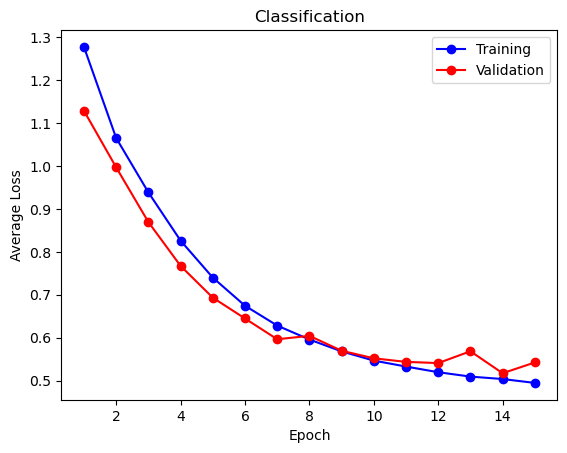

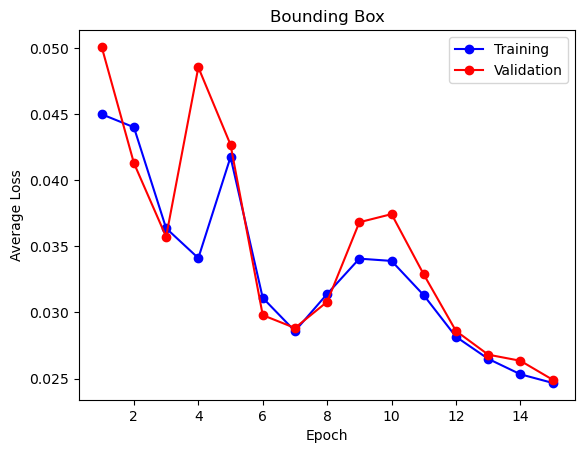

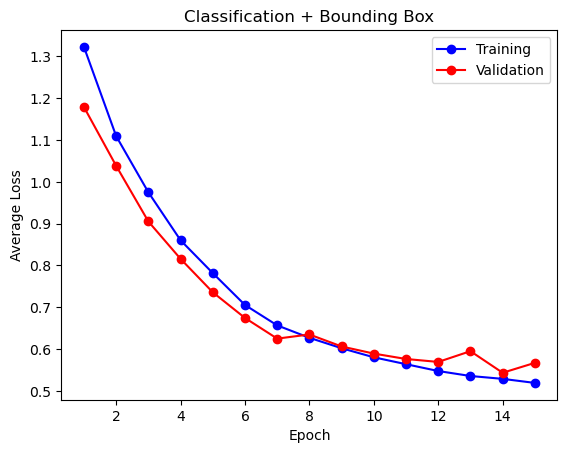

In [15]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 15, Learning Rate = 1e-3
model_15_1e_3 = RCNN().to(device)
optimizer = torch.optim.SGD(model_15_1e_3.parameters(), lr=1e-3)
epochs = 15
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}\n".format(validation_losses[t][3]))

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_15_1e_3.state_dict(), "./models/rcnn_15_1e_3.pth")

Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.607970, bbox loss: 0.565050, combined loss: 2.173019  [   32/23649]
Batch    50, classification loss: 1.619205, bbox loss: 0.876250, combined loss: 2.495456  [ 1632/23649]
Batch   100, classification loss: 1.618464, bbox loss: 0.781369, combined loss: 2.399833  [ 3232/23649]
Batch   150, classification loss: 1.633139, bbox loss: 1.062260, combined loss: 2.695399  [ 4832/23649]
Batch   200, classification loss: 1.609521, bbox loss: 0.000000, combined loss: 1.609521  [ 6432/23649]
Batch   250, classification loss: 1.621956, bbox loss: 0.563646, combined loss: 2.185602  [ 8032/23649]
Batch   300, classification loss: 1.619385, bbox loss: 0.750066, combined loss: 2.369450  [ 9632/23649]
Batch   350, classification loss: 1.616939, bbox loss: 0.513578, combined loss: 2.130518  [11232/23649]
Batch   400, classification loss: 1.614860, bbox loss: 1.103392, combined loss: 2.718252  [12832/23649]
Batch   450, c

Batch   300, classification loss: 1.554138, bbox loss: 0.133217, combined loss: 1.687355  [ 9632/23649]
Batch   350, classification loss: 1.565669, bbox loss: 0.094410, combined loss: 1.660079  [11232/23649]
Batch   400, classification loss: 1.562249, bbox loss: 0.122830, combined loss: 1.685078  [12832/23649]
Batch   450, classification loss: 1.548781, bbox loss: 0.098913, combined loss: 1.647694  [14432/23649]
Batch   500, classification loss: 1.540232, bbox loss: 0.168468, combined loss: 1.708699  [16032/23649]
Batch   550, classification loss: 1.554070, bbox loss: 0.149099, combined loss: 1.703170  [17632/23649]
Batch   600, classification loss: 1.537483, bbox loss: 0.124902, combined loss: 1.662386  [19232/23649]
Batch   650, classification loss: 1.553979, bbox loss: 0.107402, combined loss: 1.661380  [20832/23649]
Batch   700, classification loss: 1.555901, bbox loss: 0.127898, combined loss: 1.683799  [22432/23649]
Avg Training Error:
	 Classification: 1.5563440367982195, Boundi

Batch   600, classification loss: 1.484343, bbox loss: 0.059186, combined loss: 1.543529  [19232/23649]
Batch   650, classification loss: 1.533672, bbox loss: 0.239296, combined loss: 1.772968  [20832/23649]
Batch   700, classification loss: 1.482580, bbox loss: 0.083265, combined loss: 1.565845  [22432/23649]
Avg Training Error:
	 Classification: 1.4968796605999406, Bounding Box: 0.0714491250006029, Combined: 1.5683287839631777
Avg Validation Error:
	 Classification: 1.4869325567224172, Bounding Box: 0.07589131157179285, Combined: 1.5628238643347885
Avg Positive Detection Accuracy: 0.3820395738203957

Epoch 10
-------------------------------
Training:
Batch     0, classification loss: 1.490169, bbox loss: 0.061332, combined loss: 1.551501  [   32/23649]
Batch    50, classification loss: 1.505377, bbox loss: 0.036011, combined loss: 1.541388  [ 1632/23649]
Batch   100, classification loss: 1.480382, bbox loss: 0.084638, combined loss: 1.565020  [ 3232/23649]
Batch   150, classification

Batch     0, classification loss: 1.446581, bbox loss: 0.015690, combined loss: 1.462271  [   32/23649]
Batch    50, classification loss: 1.476311, bbox loss: 0.000000, combined loss: 1.476311  [ 1632/23649]
Batch   100, classification loss: 1.419738, bbox loss: 0.039175, combined loss: 1.458913  [ 3232/23649]
Batch   150, classification loss: 1.399666, bbox loss: 0.027889, combined loss: 1.427555  [ 4832/23649]
Batch   200, classification loss: 1.384751, bbox loss: 0.044906, combined loss: 1.429657  [ 6432/23649]
Batch   250, classification loss: 1.461421, bbox loss: 0.074384, combined loss: 1.535805  [ 8032/23649]
Batch   300, classification loss: 1.408272, bbox loss: 0.000000, combined loss: 1.408272  [ 9632/23649]
Batch   350, classification loss: 1.459540, bbox loss: 0.026247, combined loss: 1.485788  [11232/23649]
Batch   400, classification loss: 1.495157, bbox loss: 0.030816, combined loss: 1.525973  [12832/23649]
Batch   450, classification loss: 1.416346, bbox loss: 0.033551,

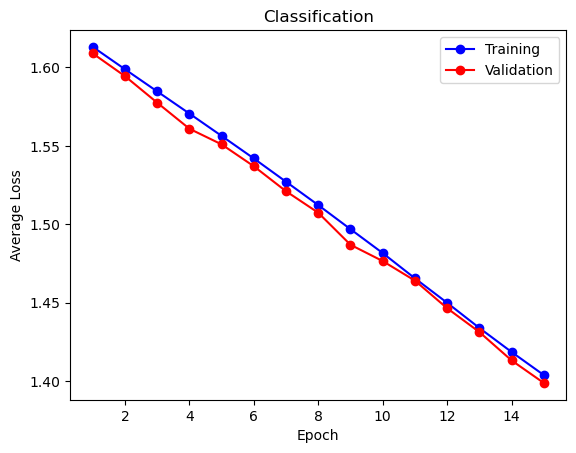

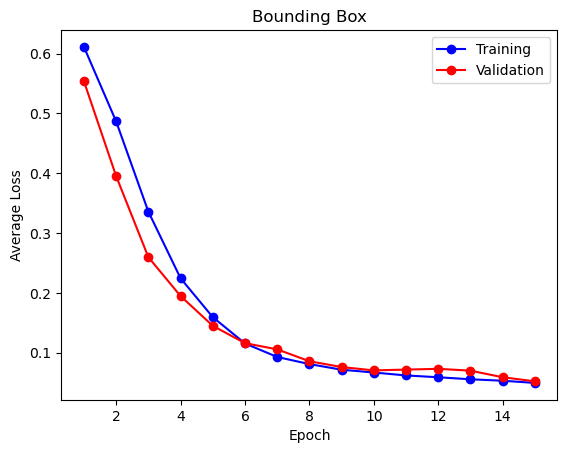

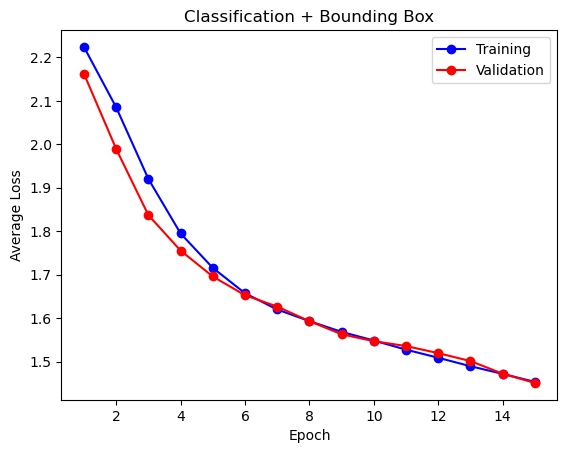

In [16]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 10, Learning Rate = 1e-5
model_15_1e_5 = RCNN().to(device)
optimizer = torch.optim.SGD(model_15_1e_5.parameters(), lr=1e-5)
epochs = 15
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}\n".format(validation_losses[t][3]))

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_15_1e_5.state_dict(), "./models/rcnn_15_1e_5.pth")

Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.635019, bbox loss: 0.000000, combined loss: 1.635019  [   32/23649]
Batch    50, classification loss: 1.501457, bbox loss: 0.266757, combined loss: 1.768214  [ 1632/23649]
Batch   100, classification loss: 1.455503, bbox loss: 0.000000, combined loss: 1.455503  [ 3232/23649]
Batch   150, classification loss: 1.299360, bbox loss: 0.000000, combined loss: 1.299360  [ 4832/23649]
Batch   200, classification loss: 1.403129, bbox loss: 0.027793, combined loss: 1.430923  [ 6432/23649]
Batch   250, classification loss: 1.331852, bbox loss: 0.000000, combined loss: 1.331852  [ 8032/23649]
Batch   300, classification loss: 1.191437, bbox loss: 0.000000, combined loss: 1.191437  [ 9632/23649]
Batch   350, classification loss: 1.313603, bbox loss: 0.000000, combined loss: 1.313603  [11232/23649]
Batch   400, classification loss: 1.167554, bbox loss: 0.000000, combined loss: 1.167554  [12832/23649]
Batch   450, c

Batch   250, classification loss: 0.858374, bbox loss: 0.021792, combined loss: 0.880166  [ 8032/23649]
Batch   300, classification loss: 0.668243, bbox loss: 0.064518, combined loss: 0.732761  [ 9632/23649]
Batch   350, classification loss: 0.811156, bbox loss: 0.062811, combined loss: 0.873967  [11232/23649]
Batch   400, classification loss: 0.622069, bbox loss: 0.028285, combined loss: 0.650354  [12832/23649]
Batch   450, classification loss: 0.776139, bbox loss: 0.024060, combined loss: 0.800199  [14432/23649]
Batch   500, classification loss: 0.556642, bbox loss: 0.030857, combined loss: 0.587499  [16032/23649]
Batch   550, classification loss: 0.858649, bbox loss: 0.031836, combined loss: 0.890485  [17632/23649]
Batch   600, classification loss: 0.822777, bbox loss: 0.024763, combined loss: 0.847539  [19232/23649]
Batch   650, classification loss: 0.738091, bbox loss: 0.021214, combined loss: 0.759305  [20832/23649]
Batch   700, classification loss: 0.604321, bbox loss: 0.033867,

Batch   550, classification loss: 0.651939, bbox loss: 0.015785, combined loss: 0.667724  [17632/23649]
Batch   600, classification loss: 0.655027, bbox loss: 0.021043, combined loss: 0.676069  [19232/23649]
Batch   650, classification loss: 0.580384, bbox loss: 0.014787, combined loss: 0.595172  [20832/23649]
Batch   700, classification loss: 0.585542, bbox loss: 0.031182, combined loss: 0.616724  [22432/23649]
Avg Training Error:
	 Classification: 0.5811934007583438, Bounding Box: 0.029320722631480847, Combined: 0.6105141233753514
Avg Validation Error:
	 Classification: 0.5748666206884651, Bounding Box: 0.030911548531421737, Combined: 0.6057781705310225
Avg Positive Detection Accuracy: 0.8643054277828887

Epoch 10
-------------------------------
Training:
Batch     0, classification loss: 0.525442, bbox loss: 0.070890, combined loss: 0.596331  [   32/23649]
Batch    50, classification loss: 0.747269, bbox loss: 0.022702, combined loss: 0.769971  [ 1632/23649]
Batch   100, classificat

Batch     0, classification loss: 0.365315, bbox loss: 0.028252, combined loss: 0.393567  [   32/23649]
Batch    50, classification loss: 0.479451, bbox loss: 0.030018, combined loss: 0.509469  [ 1632/23649]
Batch   100, classification loss: 0.539150, bbox loss: 0.021179, combined loss: 0.560329  [ 3232/23649]
Batch   150, classification loss: 0.351188, bbox loss: 0.021347, combined loss: 0.372535  [ 4832/23649]
Batch   200, classification loss: 0.336004, bbox loss: 0.028958, combined loss: 0.364962  [ 6432/23649]
Batch   250, classification loss: 0.561574, bbox loss: 0.014090, combined loss: 0.575664  [ 8032/23649]
Batch   300, classification loss: 0.461895, bbox loss: 0.016015, combined loss: 0.477910  [ 9632/23649]
Batch   350, classification loss: 0.429360, bbox loss: 0.012061, combined loss: 0.441421  [11232/23649]
Batch   400, classification loss: 0.513574, bbox loss: 0.034040, combined loss: 0.547614  [12832/23649]
Batch   450, classification loss: 0.525271, bbox loss: 0.020249,

Batch   300, classification loss: 0.378116, bbox loss: 0.029179, combined loss: 0.407295  [ 9632/23649]
Batch   350, classification loss: 0.383272, bbox loss: 0.021197, combined loss: 0.404469  [11232/23649]
Batch   400, classification loss: 0.423893, bbox loss: 0.014172, combined loss: 0.438065  [12832/23649]
Batch   450, classification loss: 0.473093, bbox loss: 0.024201, combined loss: 0.497294  [14432/23649]
Batch   500, classification loss: 0.519200, bbox loss: 0.010817, combined loss: 0.530017  [16032/23649]
Batch   550, classification loss: 0.396385, bbox loss: 0.020176, combined loss: 0.416561  [17632/23649]
Batch   600, classification loss: 0.444214, bbox loss: 0.021182, combined loss: 0.465396  [19232/23649]
Batch   650, classification loss: 0.487191, bbox loss: 0.020835, combined loss: 0.508026  [20832/23649]
Batch   700, classification loss: 0.452426, bbox loss: 0.028205, combined loss: 0.480631  [22432/23649]
Avg Training Error:
	 Classification: 0.4767802292027989, Boundi

Batch   600, classification loss: 0.476171, bbox loss: 0.031654, combined loss: 0.507825  [19232/23649]
Batch   650, classification loss: 0.351181, bbox loss: 0.021597, combined loss: 0.372778  [20832/23649]
Batch   700, classification loss: 0.433804, bbox loss: 0.015167, combined loss: 0.448971  [22432/23649]
Avg Training Error:
	 Classification: 0.45399516841044296, Bounding Box: 0.022062725280537397, Combined: 0.4760578937627174
Avg Validation Error:
	 Classification: 0.47683222525279617, Bounding Box: 0.022870274799142304, Combined: 0.4997024989827385
Avg Positive Detection Accuracy: 0.9338810641627543

Epoch 23
-------------------------------
Training:
Batch     0, classification loss: 0.689864, bbox loss: 0.021799, combined loss: 0.711663  [   32/23649]
Batch    50, classification loss: 0.631258, bbox loss: 0.029605, combined loss: 0.660864  [ 1632/23649]
Batch   100, classification loss: 0.543425, bbox loss: 0.021930, combined loss: 0.565355  [ 3232/23649]
Batch   150, classific

Batch     0, classification loss: 0.788730, bbox loss: 0.019929, combined loss: 0.808659  [   32/23649]
Batch    50, classification loss: 0.429288, bbox loss: 0.015696, combined loss: 0.444985  [ 1632/23649]
Batch   100, classification loss: 0.733964, bbox loss: 0.014623, combined loss: 0.748587  [ 3232/23649]
Batch   150, classification loss: 0.498243, bbox loss: 0.024343, combined loss: 0.522587  [ 4832/23649]
Batch   200, classification loss: 0.525167, bbox loss: 0.017003, combined loss: 0.542170  [ 6432/23649]
Batch   250, classification loss: 0.541950, bbox loss: 0.025221, combined loss: 0.567171  [ 8032/23649]
Batch   300, classification loss: 0.623614, bbox loss: 0.019776, combined loss: 0.643390  [ 9632/23649]
Batch   350, classification loss: 0.427467, bbox loss: 0.023748, combined loss: 0.451215  [11232/23649]
Batch   400, classification loss: 0.349044, bbox loss: 0.011449, combined loss: 0.360493  [12832/23649]
Batch   450, classification loss: 0.328035, bbox loss: 0.027157,

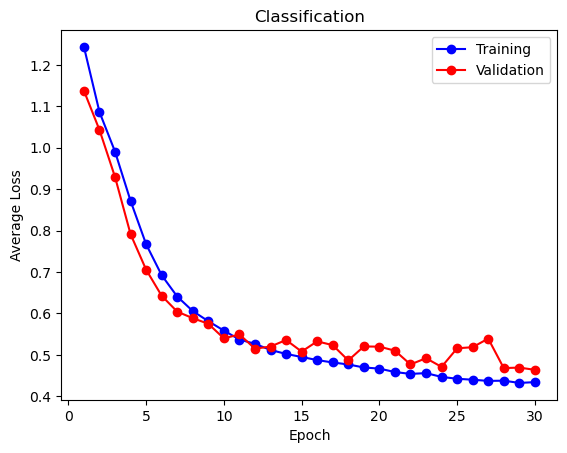

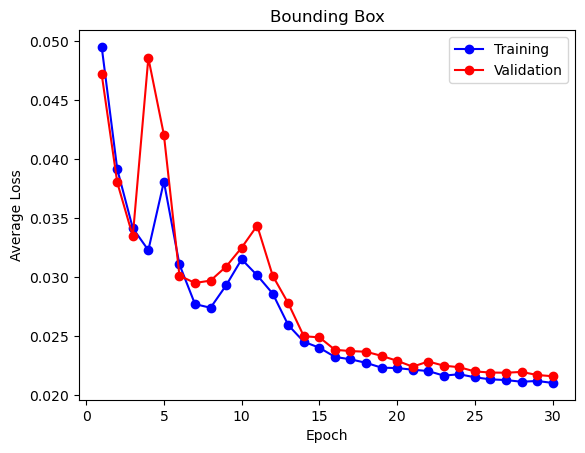

Traceback (most recent call last):
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/gpfs/u/home/CVC1/CVC1gnnv/scratch/miniconda3/lib/python3.7/multiprocessing/connection.py", line 177, in 

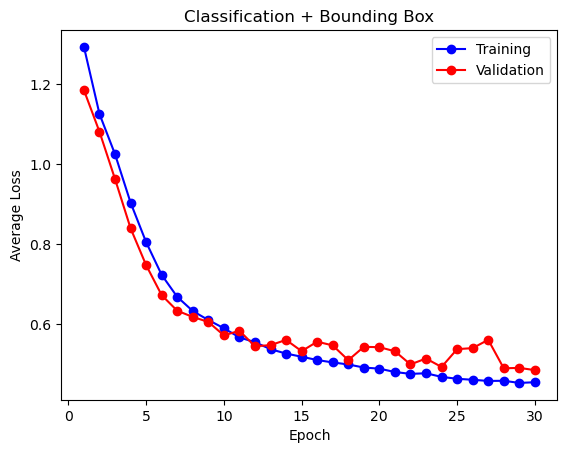

In [18]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 30, Learning Rate = 1e-3
model_30_1e_3 = RCNN().to(device)
optimizer = torch.optim.SGD(model_30_1e_3.parameters(), lr=1e-3)
epochs = 30
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}\n".format(validation_losses[t][3]))

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_30_1e_3.state_dict(), "./models/rcnn_30_1e_3.pth")

Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.623147, bbox loss: 0.000000, combined loss: 1.623147  [   32/23649]
Batch    50, classification loss: 1.573304, bbox loss: 0.000000, combined loss: 1.573304  [ 1632/23649]
Batch   100, classification loss: 1.433440, bbox loss: 0.000000, combined loss: 1.433440  [ 3232/23649]
Batch   150, classification loss: 1.372271, bbox loss: 0.047574, combined loss: 1.419845  [ 4832/23649]
Batch   200, classification loss: 1.185593, bbox loss: 0.058859, combined loss: 1.244452  [ 6432/23649]
Batch   250, classification loss: 1.283172, bbox loss: 0.020830, combined loss: 1.304002  [ 8032/23649]
Batch   300, classification loss: 1.154398, bbox loss: 0.024324, combined loss: 1.178722  [ 9632/23649]
Batch   350, classification loss: 1.000872, bbox loss: 0.025716, combined loss: 1.026588  [11232/23649]
Batch   400, classification loss: 1.185025, bbox loss: 0.039352, combined loss: 1.224376  [12832/23649]
Batch   450, c

Batch   200, classification loss: 0.876913, bbox loss: 0.028845, combined loss: 0.905758  [ 6432/23649]
Batch   250, classification loss: 0.754304, bbox loss: 0.015616, combined loss: 0.769920  [ 8032/23649]
Batch   300, classification loss: 0.636832, bbox loss: 0.031725, combined loss: 0.668557  [ 9632/23649]
Batch   350, classification loss: 0.629985, bbox loss: 0.032393, combined loss: 0.662378  [11232/23649]
Batch   400, classification loss: 0.586999, bbox loss: 0.033854, combined loss: 0.620853  [12832/23649]
Batch   450, classification loss: 0.677381, bbox loss: 0.018797, combined loss: 0.696177  [14432/23649]
Batch   500, classification loss: 0.724452, bbox loss: 0.050087, combined loss: 0.774538  [16032/23649]
Batch   550, classification loss: 0.751700, bbox loss: 0.032281, combined loss: 0.783981  [17632/23649]
Batch   600, classification loss: 0.658760, bbox loss: 0.026680, combined loss: 0.685440  [19232/23649]
Batch   650, classification loss: 0.520476, bbox loss: 0.027586,

Batch   450, classification loss: 0.739080, bbox loss: 0.031881, combined loss: 0.770961  [14432/23649]
Batch   500, classification loss: 0.642563, bbox loss: 0.025810, combined loss: 0.668374  [16032/23649]
Batch   550, classification loss: 0.335897, bbox loss: 0.026945, combined loss: 0.362842  [17632/23649]
Batch   600, classification loss: 0.621618, bbox loss: 0.025175, combined loss: 0.646793  [19232/23649]
Batch   650, classification loss: 0.524147, bbox loss: 0.017415, combined loss: 0.541562  [20832/23649]
Batch   700, classification loss: 0.788269, bbox loss: 0.077960, combined loss: 0.866229  [22432/23649]
Avg Training Error:
	 Classification: 0.5603578124497388, Bounding Box: 0.030875143367243375, Combined: 0.59123295545578
Avg Validation Error:
	 Classification: 0.5929910493962591, Bounding Box: 0.030917126362799932, Combined: 0.6239081746040109
Avg Positive Detection Accuracy: 0.8595127008812856
Avg IOU: {:}
 0.6449020474409142
Epoch 10
-------------------------------
Trai

Batch   700, classification loss: 0.534697, bbox loss: 0.033133, combined loss: 0.567830  [22432/23649]
Avg Training Error:
	 Classification: 0.502143391886273, Bounding Box: 0.02460466678556357, Combined: 0.5267480578776952
Avg Validation Error:
	 Classification: 0.5183052367338256, Bounding Box: 0.025590615669608782, Combined: 0.5438958483035338
Avg Positive Detection Accuracy: 0.8853102906520032
Avg IOU: {:}
 0.661153448452757
Epoch 14
-------------------------------
Training:
Batch     0, classification loss: 0.523748, bbox loss: 0.037596, combined loss: 0.561344  [   32/23649]
Batch    50, classification loss: 0.574273, bbox loss: 0.014172, combined loss: 0.588445  [ 1632/23649]
Batch   100, classification loss: 0.478455, bbox loss: 0.029280, combined loss: 0.507735  [ 3232/23649]
Batch   150, classification loss: 0.569013, bbox loss: 0.028214, combined loss: 0.597228  [ 4832/23649]
Batch   200, classification loss: 0.265876, bbox loss: 0.022095, combined loss: 0.287971  [ 6432/23

Batch     0, classification loss: 0.474397, bbox loss: 0.020286, combined loss: 0.494683  [   32/23649]
Batch    50, classification loss: 0.275856, bbox loss: 0.018378, combined loss: 0.294235  [ 1632/23649]
Batch   100, classification loss: 0.439461, bbox loss: 0.026190, combined loss: 0.465651  [ 3232/23649]
Batch   150, classification loss: 0.649258, bbox loss: 0.035935, combined loss: 0.685194  [ 4832/23649]
Batch   200, classification loss: 0.330830, bbox loss: 0.017230, combined loss: 0.348059  [ 6432/23649]
Batch   250, classification loss: 0.529983, bbox loss: 0.031351, combined loss: 0.561334  [ 8032/23649]
Batch   300, classification loss: 0.490295, bbox loss: 0.025983, combined loss: 0.516278  [ 9632/23649]
Batch   350, classification loss: 0.438703, bbox loss: 0.023051, combined loss: 0.461754  [11232/23649]
Batch   400, classification loss: 0.552528, bbox loss: 0.018637, combined loss: 0.571165  [12832/23649]
Batch   450, classification loss: 0.438485, bbox loss: 0.024554,

Batch   250, classification loss: 0.376567, bbox loss: 0.025072, combined loss: 0.401640  [ 8032/23649]
Batch   300, classification loss: 0.492531, bbox loss: 0.025952, combined loss: 0.518483  [ 9632/23649]
Batch   350, classification loss: 0.431808, bbox loss: 0.029915, combined loss: 0.461723  [11232/23649]
Batch   400, classification loss: 0.436964, bbox loss: 0.031535, combined loss: 0.468500  [12832/23649]
Batch   450, classification loss: 0.214905, bbox loss: 0.018012, combined loss: 0.232916  [14432/23649]
Batch   500, classification loss: 0.484344, bbox loss: 0.028791, combined loss: 0.513135  [16032/23649]
Batch   550, classification loss: 0.317165, bbox loss: 0.012051, combined loss: 0.329217  [17632/23649]
Batch   600, classification loss: 0.506281, bbox loss: 0.024607, combined loss: 0.530888  [19232/23649]
Batch   650, classification loss: 0.489984, bbox loss: 0.021036, combined loss: 0.511020  [20832/23649]
Batch   700, classification loss: 0.450810, bbox loss: 0.023128,

Batch   500, classification loss: 0.276876, bbox loss: 0.013143, combined loss: 0.290019  [16032/23649]
Batch   550, classification loss: 0.720337, bbox loss: 0.022702, combined loss: 0.743039  [17632/23649]
Batch   600, classification loss: 0.663251, bbox loss: 0.009158, combined loss: 0.672409  [19232/23649]
Batch   650, classification loss: 0.244161, bbox loss: 0.020826, combined loss: 0.264987  [20832/23649]
Batch   700, classification loss: 0.633562, bbox loss: 0.018827, combined loss: 0.652388  [22432/23649]
Avg Training Error:
	 Classification: 0.43614562173952925, Bounding Box: 0.021322374617227833, Combined: 0.45746799628879575
Avg Validation Error:
	 Classification: 0.534401910764545, Bounding Box: 0.020868844755888818, Combined: 0.5552707544252193
Avg Positive Detection Accuracy: 0.9362232187344295
Avg IOU: {:}
 0.6958465528936832
Epoch 27
-------------------------------
Training:
Batch     0, classification loss: 0.427364, bbox loss: 0.021582, combined loss: 0.448946  [   3

Avg Training Error:
	 Classification: 0.4229633129730418, Bounding Box: 0.021013172288626633, Combined: 0.4439764855479872
Avg Validation Error:
	 Classification: 0.5278251882038969, Bounding Box: 0.020507062577210657, Combined: 0.548332249652074
Avg Positive Detection Accuracy: 0.9381800197823936
Avg IOU: {:}
 0.6992714232194799
Training Confusion Matrix
Validation Confusion Matrix
[[8813   95  179  107 1150]
 [ 163  446   20   15  109]
 [ 290    1 1568    9  196]
 [ 145   27   24  407  121]
 [1049   31   94   46 8544]]
[[2509   22   74   18   65]
 [  77  106    0    0    2]
 [ 115    0  395    4   23]
 [  62    4    4   90   13]
 [ 654   15   27    4 1431]]


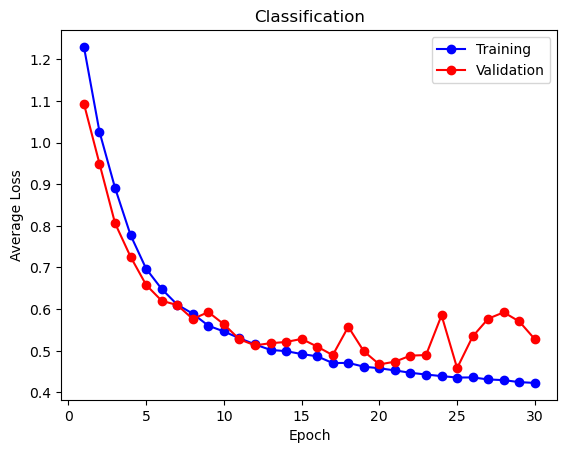

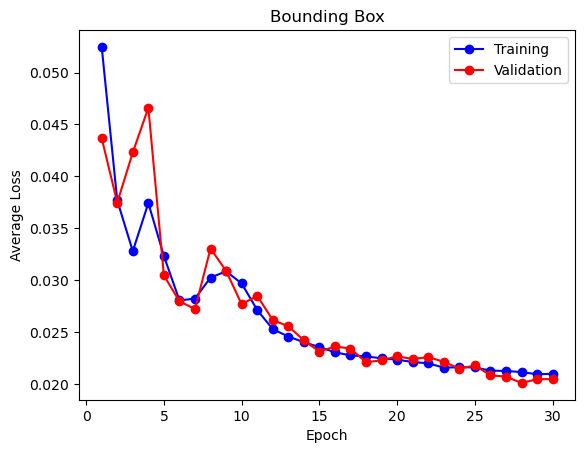

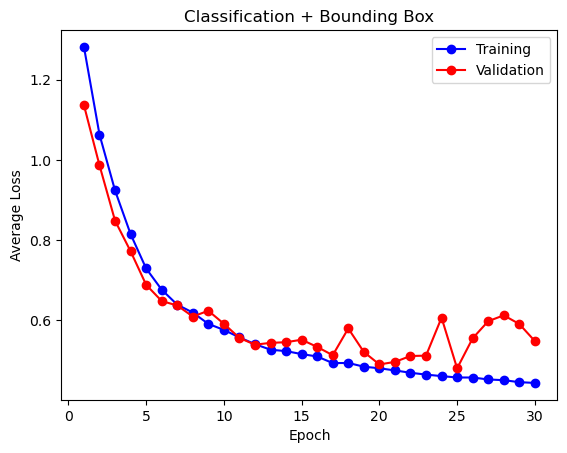

In [17]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 30, Learning Rate = 1e-3
model_30_1e_3 = RCNN().to(device)
optimizer = torch.optim.SGD(model_30_1e_3.parameters(), lr=1e-3)
epochs = 30
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_30_1e_3, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}".format(validation_losses[t][3]))
    print("Avg IOU: {:}\n", validation_losses[t][4])

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_30_1e_3.state_dict(), "./models/rcnn_30_1e_3_redo.pth")

In [67]:
def rescale_bounding_boxes(cand_bboxes_list, detection_bboxes_list):
    cand_bboxes_tensor, detection_bboxes_tensor = torch.as_tensor(cand_bboxes_list), torch.as_tensor(detection_bboxes_list)
    x_scales, y_scales = 224 / (cand_bboxes_tensor[:,[2]] - cand_bboxes_tensor[:,[0]] + 0.1) , 224 / (cand_bboxes_tensor[:,[3]] - cand_bboxes_tensor[:,[1]] + 0.1)
    detection_bboxes_tensor[:,[0, 2]] = (detection_bboxes_tensor[:,[0, 2]] * 224 / x_scales) + cand_bboxes_tensor[:,[0, 0]]
    detection_bboxes_tensor[:,[1, 3]] = (detection_bboxes_tensor[:,[1, 3]] * 224 / y_scales) + cand_bboxes_tensor[:,[1, 1]]
    return detection_bboxes_tensor


def predictions_to_detections(cand_bboxes, predictions_classes, predictions_bboxes, iou_threshold=0.5):
    """
    Output: List of region predictions that are considered to be
    detection results. These are ordered by activation with all class
    0 predictions eliminated, and the non-maximum suppression
    applied.
    """
    #Get all of the non 0 class predictions
    predicted_classes = torch.argmax(predictions_classes, dim=1)
    nonzero_detections_mask = (predicted_classes > 0)
    detected_bboxes_all = predictions_bboxes[nonzero_detections_mask,:]
    detected_cand_bboxes = cand_bboxes[nonzero_detections_mask,:]
    
    detected_classes = predicted_classes[nonzero_detections_mask]
    class_indices = torch.transpose(torch.cat(((detected_classes * 4 - 4).view(1,-1), \
                                             (detected_classes * 4 - 3).view(1,-1), \
                                             (detected_classes * 4 - 2).view(1,-1), \
                                             (detected_classes * 4 - 1).view(1,-1)), dim=0), 0,1)
    detected_bboxes = detected_bboxes_all.gather(1, class_indices)
    activations = predictions_classes[nonzero_detections_mask,:].gather(1, detected_classes.view(-1,1))
    #Highest activation at the front
    sorted_detected_classes_list = detected_classes[torch.flatten(torch.argsort(activations, 0, descending=True)).tolist()].tolist()
    sorted_detected_bboxes_list = detected_bboxes[torch.flatten(torch.argsort(activations, 0, descending=True)).tolist(),:].tolist()
    sorted_cand_bboxes_list = detected_cand_bboxes[torch.flatten(torch.argsort(activations, 0, descending=True)).tolist(),:].tolist()
    
    #Non-maximum suppression
    surpressed = []
    remaining = sorted_detected_bboxes_list.copy()
    keep_bboxes = []
    keep_classes = []
    keep_cand_bboxes = []
    for i in range(len(remaining)):
        rest_predictions = [remaining[j] for j in range(len(remaining)) if remaining[j] != remaining[i] and sorted_detected_classes_list[j] == sorted_detected_classes_list[i]]
        for j in range(len(rest_predictions)):
        #If we can surpress the next prediction:
            if iou(remaining[i], rest_predictions[j]) >= iou_threshold:
                if rest_predictions[j] not in surpressed:
                    surpressed.append(rest_predictions[j])
        if remaining[i] not in surpressed:
            keep_bboxes.append(remaining[i])
            keep_classes.append(sorted_detected_classes_list[i])
            keep_cand_bboxes.append(sorted_cand_bboxes_list[i])
    return keep_bboxes, keep_classes, keep_cand_bboxes



def evaluate(detections_classes, detections_bboxes, gt_detections_classes, gt_detections_bboxes, n=10):
    """
    Returns:
    list of correct detections (bounding boxes and class labels),
    list of incorrect detections (bounding boxes and class labels),
    list of ground truth regions that are missed (bounding boxes and class labels),
    AP@n value.
    """
    
    gt_detections_classes_copy, gt_detections_bboxes_copy = gt_detections_classes.copy(), gt_detections_bboxes.copy()
    regions_size = min(len(gt_detections_bboxes_copy), n)
    B_vector = []
    correct_classes, correct_bboxes = [], []
    incorrect_classes, incorrect_bboxes = [], []
    ground_truthes_classes, ground_truthes_bboxes = [], []
    

    for i in range(len(detections_bboxes[:regions_size])):#Consider at most 'n' detections
        max_IOU = 0
        g_index = None
        for j in range(len(gt_detections_bboxes_copy)):
            if detections_classes[i] == gt_detections_classes_copy[j] and iou(detections_bboxes[i], gt_detections_bboxes_copy[j]) > max_IOU:
                max_IOU = iou(detections_bboxes[i], gt_detections_bboxes_copy[j])
                g_index = j
        if g_index == None or max_IOU < 0.5:
            #If no ground truth value exits for this detection, or if the best ground truth IOU is below 0.5 threshold
            B_vector.append(0)
        else:
            B_vector.append(1)
            correct_classes.append(detections_classes[i])
            correct_bboxes.append(detections_bboxes[i])
            ground_truthes_classes.append(gt_detections_classes[g_index])
            ground_truthes_bboxes.append(gt_detections_bboxes_copy[g_index])
            del gt_detections_classes_copy[g_index]
            del gt_detections_bboxes_copy[g_index]
    B_vector += [0]*(n - regions_size)#Fill B_vector with 0's if number of predicted detections was below 10
    precisions = []
    for i in range(len(B_vector)):
        #Gathering the Precisions at i (the fraction of first i items retrieved that are correct)
        precisions.append(sum(B_vector[0:i+1]) / (i+1))
    average_precision = np.sum(np.array(B_vector)*np.array(precisions)) / min(len(gt_detections_bboxes), n)
    return list(zip(correct_classes, correct_bboxes)),\
        [(detections_classes[i], detections_bboxes[i]) for i in range(len(detections_bboxes)) if detections_bboxes[i] not in correct_bboxes],\
        [(gt_detections_classes[i], gt_detections_bboxes[i]) for i in range(len(gt_detections_bboxes)) if gt_detections_bboxes[i] not in ground_truthes_bboxes],\
        average_precision

In [57]:
best_model = RCNN().to(device)
best_model.load_state_dict(torch.load("./models/rcnn_30_1e_3.pth"
                                        ,map_location=device))
ROOT_aimos = "."
TEST_FILES_aimos, TEST_JSON_aimos = 'drive-data/test', 'drive-data/test.json'
testing_dataset = datasets.HW6DatasetTest(os.path.join(ROOT_aimos, TEST_FILES_aimos), os.path.join(ROOT_aimos, TEST_JSON_aimos))
testing_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False, num_workers=6, pin_memory=True)

In [72]:
best_model.eval()
mAP = 0
labels = {0: 'nothing', 1: 'bicycle', 2: 'car', 3: 'motorbike', 4: 'person'}
for index, (image, cand_regions, cand_bboxes, gt_bboxes, gt_classes) in enumerate(testing_loader):
    cand_regions, cand_bboxes, gt_bboxes, gt_classes = cand_regions.to(device).float().squeeze(0), \
                                                        cand_bboxes.to(device).to(torch.int64).squeeze(0), \
                                                        gt_bboxes.to(device).float().squeeze(0), \
                                                        gt_classes.to(device).to(torch.int64).squeeze(0)
    image = image.squeeze(0).numpy()
    pred_classifications, pred_bboxes = best_model(cand_regions)

    #Post processing: Form the actual detections by filtering out 0 class predictions, and to NMS
    filtered_detections_bboxes, filtered_detections_classes, filtered_cand_bboxes =\
                    predictions_to_detections(cand_bboxes, pred_classifications, pred_bboxes, iou_threshold=0.5)
    print(filtered_cand_bboxes)
    if (len(filtered_detections_bboxes) == 0):
        print("No detections found")
        continue
    #Rescale the detection bounding boxes to be in the ground truth coordinate system (original image coordinate system)
    filtered_detections_bboxes = rescale_bounding_boxes(filtered_cand_bboxes, filtered_detections_bboxes).tolist()
    correct_detections, incorrect_detections, missed, AP = evaluate(filtered_detections_classes, filtered_detections_bboxes, gt_classes.tolist(), gt_bboxes.tolist(), n=10)
    print(len(correct_detections))
    print((incorrect_detections))
    print(len(missed))
    print("Average Precision:", AP)
    print()
    mAP += AP
    
    if index in [1, 16, 28, 30, 39, 75, 78, 88, 93, 146]:
        for class_label, box in correct_detections:
            image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,255,0), 2)
            image = cv2.putText(image, labels[class_label], (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,255,0), 1)

        for class_label, box in incorrect_detections:
            image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255), 2)
            image = cv2.putText(image, labels[class_label], (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,0,255), 1)
        for class_label, box in missed:
            image = cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,255,255), 2)
            image = cv2.putText(image, labels[class_label], (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0,255,255), 1)
        cv2.imwrite("final_images/{:}.png".format(index), image)
print("Mean Average Precision:", mAP / len(testing_loader.dataset))


[[0, 99, 375, 359]]
tensor([[0.5972]])
tensor([[0.8612]])
IOU: 0.8591023667043872
1
[]
0
Average Precision: 1.0

[[18, 0, 185, 252]]
tensor([[1.3405]])
tensor([[0.8885]])
IOU: 0.2211208693971969
IOU: 0.6368073951289099
1
[]
1
Average Precision: 0.5

[[0, 2, 244, 428]]
tensor([[0.9177]])
tensor([[0.5257]])
IOU: 0.648695649677991
1
[]
0
Average Precision: 1.0

[[215, 0, 469, 157]]
tensor([[0.8815]])
tensor([[1.4258]])
IOU: 0.2844201488988685
0
[(3, [212.3852996826172, 17.698511123657227, 489.85015869140625, 176.97291564941406])]
1
Average Precision: 0.0

[[0, 104, 378, 392]]
tensor([[0.5924]])
tensor([[0.7775]])
IOU: 0.6893408429843669
1
[]
0
Average Precision: 1.0

[[194, 144, 333, 336]]
tensor([[1.6104]])
tensor([[1.1661]])
IOU: 0
0
[(2, [194.71456909179688, 161.423095703125, 349.4856262207031, 348.107421875])]
1
Average Precision: 0.0

[[1, 78, 192, 468]]
tensor([[1.1722]])
tensor([[0.5742]])
IOU: 0.5177100362802267
1
[]
0
Average Precision: 1.0

[[0, 304, 25, 334]]
tensor([[8.9243]])

[[0, 125, 333, 326]]
tensor([[0.6725]])
tensor([[1.1139]])
IOU: 0.7392993402061824
1
[]
0
Average Precision: 1.0

[]
No detections found
[[300, 82, 346, 268], [165, 113, 346, 341]]
tensor([[4.8590],
        [1.2369]])
tensor([[1.2037],
        [0.9820]])
IOU: 0.25451721083515977
IOU: 0.5873364146280874
IOU: 0.5489598675940202
2
[]
1
Average Precision: 0.6666666666666666

[[0, 25, 375, 347]]
tensor([[0.5972]])
tensor([[0.6954]])
IOU: 0.6465766472313291
1
[]
1
Average Precision: 0.5

[[200, 93, 354, 190], [100, 109, 211, 201]]
tensor([[1.4536],
        [2.0162]])
tensor([[2.3069],
        [2.4321]])
IOU: 0.11039116614127441
IOU: 0.6054180896384412
1
[(2, [198.05718994140625, 88.3140640258789, 365.6805725097656, 192.958984375])]
1
Average Precision: 0.25

[[0, 90, 55, 120]]
tensor([[4.0653]])
tensor([[7.4419]])
IOU: 0.08340818252034815
IOU: 0.009621611564631483
IOU: 0.8799430147415394
1
[]
3
Average Precision: 0.25

[[226, 133, 261, 190]]
tensor([[6.3818]])
tensor([[3.9229]])
IOU: 0.62568

[[284, 91, 449, 208]]
tensor([[1.3568]])
tensor([[1.9129]])
IOU: 0.17426820199624588
0
[(1, [293.4742126464844, 93.01290893554688, 460.2448425292969, 213.12818908691406])]
1
Average Precision: 0.0

[[161, 160, 220, 294]]
tensor([[3.7902]])
tensor([[1.6704]])
IOU: 0.6508890134518598
1
[]
0
Average Precision: 1.0

[[0, 126, 224, 226]]
tensor([[0.9996]])
tensor([[2.2378]])
IOU: 0.291889272572303
0
[(2, [25.192684173583984, 127.31655883789062, 230.52210998535156, 217.36546325683594])]
1
Average Precision: 0.0

[[89, 0, 269, 416]]
tensor([[1.2438]])
tensor([[0.5383]])
IOU: 0.6439527278530416
1
[]
0
Average Precision: 1.0

[]
No detections found
[[0, 253, 183, 380]]
tensor([[1.2234]])
tensor([[1.7624]])
IOU: 0.61364260441984
1
[]
0
Average Precision: 1.0

[[95, 114, 257, 302]]
tensor([[1.3819]])
tensor([[1.1909]])
IOU: 0.739369008681576
IOU: 0.011322345796522257
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0
1
[]
8
Average Precision: 0.1111111111111111

[[152, 0, 218, 377]]
tensor([[3.3888

[[23, 149, 375, 370]]
tensor([[0.6362]])
tensor([[1.0131]])
IOU: 0.5315165862026062
1
[]
0
Average Precision: 1.0

[[64, 47, 343, 405]]
tensor([[0.8026]])
tensor([[0.6255]])
IOU: 0.5810519106396898
IOU: 0.6847819904264353
IOU: 0.15657316795367676
1
[]
2
Average Precision: 0.3333333333333333

[[317, 103, 375, 196]]
tensor([[3.8554]])
tensor([[2.4060]])
IOU: 0
IOU: 0.5574950151255151
1
[]
1
Average Precision: 0.5

[[101, 15, 375, 403], [189, 0, 443, 131]]
tensor([[0.8172],
        [0.8815]])
tensor([[0.5772],
        [1.7086]])
IOU: 0.8434465904855812
IOU: 0.3698766677228146
IOU: 0.06681302365806258
1
[(2, [212.54922485351562, 5.449235439300537, 453.45751953125, 136.17214965820312])]
2
Average Precision: 0.3333333333333333

[[288, 70, 375, 270]]
tensor([[2.5718]])
tensor([[1.1194]])
IOU: 0
IOU: 0.6309938220633485
IOU: 0.23595669975009417
1
[]
2
Average Precision: 0.3333333333333333

[[289, 178, 352, 260]]
tensor([[3.5499]])
tensor([[2.7284]])
IOU: 0.7489703785564158
IOU: 0.01522595680456

[[237, 16, 375, 296]]
tensor([[1.6220]])
tensor([[0.7997]])
IOU: 0.7053106152822194
1
[]
1
Average Precision: 0.5

[[177, 297, 192, 337], [15, 312, 40, 332]]
tensor([[14.8344],
        [ 8.9243]])
tensor([[ 5.5860],
        [11.1443]])
IOU: 0
0
[(4, [176.54458618164062, 299.177001953125, 193.60348510742188, 336.7663879394531]), (3, [16.99446678161621, 312.8341979980469, 39.681236267089844, 334.2591247558594])]
7
Average Precision: 0.0

[]
No detections found
[[219, 106, 248, 222]]
tensor([[7.6976]])
tensor([[1.9294]])
IOU: 0.5317686335870256
IOU: 0
1
[]
2
Average Precision: 0.3333333333333333

[[244, 113, 375, 354]]
tensor([[1.7086]])
tensor([[0.9291]])
IOU: 0.7031753283680631
IOU: 0
1
[]
1
Average Precision: 0.5

[]
No detections found
[[3, 189, 61, 310]]
tensor([[3.8554]])
tensor([[1.8497]])
IOU: 0.5455454625310769
1
[]
1
Average Precision: 0.5

[[186, 6, 277, 293]]
tensor([[2.4588]])
tensor([[0.7802]])
IOU: 0.687145461152523
1
[]
1
Average Precision: 0.5

[[65, 145, 110, 182]]
tenso

IOU: 0.5883190998524551
IOU: 0
1
[]
1
Average Precision: 0.5

[[23, 0, 321, 227]]
tensor([[0.7514]])
tensor([[0.9863]])
IOU: 0.39646014520313694
0
[(2, [-17.580341339111328, -6.460864543914795, 384.8521423339844, 236.60011291503906])]
1
Average Precision: 0.0

[[19, 109, 38, 193], [91, 163, 153, 225]]
tensor([[11.7277],
        [ 3.6071]])
tensor([[2.6635],
        [3.6071]])
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0.5371936982270196
IOU: 0.16808064804447775
IOU: 0.15701725747854686
IOU: 0
IOU: 0
IOU: 0
IOU: 0
IOU: 0.36617533822163195
IOU: 0.6235889219615992
IOU: 0.04550855253273793
IOU: 0.17216023695962065
IOU: 0.6908847026889733
IOU: 0.09211367034629994
IOU: 0.1504449613101164
2
[]
17
Average Precision: 0.2

[[0, 210, 19, 268]]
tensor([[11.7277]])
tensor([[3.8554]])
IOU: 0
IOU: 0
IOU: 0.8347593799604697
1
[]
6
Average Precision: 0.14285714285714285

[[103, 37, 175, 76], [113, 21, 368, 389]]
tensor([[3.1068],
        [0.8781]])
tensor([[5.7289],
        [0.6085]])
IOU: 0.7779076307813

[[11, 71, 150, 281]]
tensor([[1.6104]])
tensor([[1.0662]])
IOU: 0
IOU: 0
IOU: 0.5939479162319388
IOU: 0.4982902342062686
1
[]
3
Average Precision: 0.25

[[174, 223, 243, 393]]
tensor([[3.2417]])
tensor([[1.3169]])
IOU: 0.6508159268561083
1
[]
0
Average Precision: 1.0

[[172, 155, 350, 278]]
tensor([[1.2577]])
tensor([[1.8197]])
IOU: 0.5349713944231393
1
[]
0
Average Precision: 1.0

[[298, 96, 346, 351]]
tensor([[4.6570]])
tensor([[0.8781]])
IOU: 0
IOU: 0.7042670092269091
IOU: 0
IOU: 0
IOU: 0
1
[]
4
Average Precision: 0.2

[[25, 104, 265, 422]]
tensor([[0.9329]])
tensor([[0.7042]])
IOU: 0.5953005233118198
1
[]
0
Average Precision: 1.0

[[207, 6, 332, 295]]
tensor([[1.7906]])
tensor([[0.7748]])
IOU: 0.588774839609979
1
[]
0
Average Precision: 1.0

[[58, 0, 333, 364]]
tensor([[0.8142]])
tensor([[0.6152]])
IOU: 0.6880723296576394
IOU: 0.5657400998131513
1
[]
1
Average Precision: 0.5

[[204, 5, 254, 30], [275, 0, 302, 30], [0, 0, 170, 338]]
tensor([[4.4711],
        [8.2657],
        [1.316

[[212, 78, 375, 417]]
tensor([[1.3734]])
tensor([[0.6606]])
IOU: 0.6446801504238887
1
[]
0
Average Precision: 1.0

[[67, 98, 375, 292]]
tensor([[0.7270]])
tensor([[1.1540]])
IOU: 0.6393301466720747
IOU: 0
IOU: 0.010509666023269961
1
[]
2
Average Precision: 0.3333333333333333

[[99, 28, 339, 375]]
tensor([[0.9329]])
tensor([[0.6453]])
IOU: 0.20836663628622282
IOU: 0.6246874530073507
1
[]
1
Average Precision: 0.5

[[168, 54, 252, 338]]
tensor([[2.6635]])
tensor([[0.7885]])
IOU: 0.610170907633463
IOU: 0.41009811147963715
1
[]
1
Average Precision: 0.5

[[0, 0, 275, 465]]
tensor([[0.8142]])
tensor([[0.4816]])
IOU: 0.6018371917795272
IOU: 0.03253590810543047
1
[]
1
Average Precision: 0.5

Mean Average Precision: 0.4310813738233092


Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.511242, bbox loss: 0.471564, combined loss: 1.982806  [   32/23649]
Batch    50, classification loss: 1.522776, bbox loss: 0.100896, combined loss: 1.623672  [ 1632/23649]
Batch   100, classification loss: 1.448242, bbox loss: 0.052140, combined loss: 1.500382  [ 3232/23649]
Batch   150, classification loss: 1.330345, bbox loss: 0.075254, combined loss: 1.405600  [ 4832/23649]
Batch   200, classification loss: 1.389539, bbox loss: 0.042916, combined loss: 1.432455  [ 6432/23649]
Batch   250, classification loss: 1.107766, bbox loss: 0.051148, combined loss: 1.158914  [ 8032/23649]
Batch   300, classification loss: 1.140540, bbox loss: 0.036429, combined loss: 1.176969  [ 9632/23649]
Batch   350, classification loss: 1.074980, bbox loss: 0.063520, combined loss: 1.138500  [11232/23649]
Batch   400, classification loss: 1.113456, bbox loss: 0.034995, combined loss: 1.148452  [12832/23649]
Batch   450, c

Batch   200, classification loss: 0.602974, bbox loss: 0.079784, combined loss: 0.682758  [ 6432/23649]
Batch   250, classification loss: 0.628180, bbox loss: 0.035060, combined loss: 0.663241  [ 8032/23649]
Batch   300, classification loss: 0.635398, bbox loss: 0.045637, combined loss: 0.681034  [ 9632/23649]
Batch   350, classification loss: 0.823185, bbox loss: 0.040978, combined loss: 0.864163  [11232/23649]
Batch   400, classification loss: 0.631755, bbox loss: 0.031509, combined loss: 0.663265  [12832/23649]
Batch   450, classification loss: 0.680689, bbox loss: 0.021247, combined loss: 0.701936  [14432/23649]
Batch   500, classification loss: 0.815699, bbox loss: 0.068831, combined loss: 0.884529  [16032/23649]
Batch   550, classification loss: 0.568835, bbox loss: 0.039921, combined loss: 0.608755  [17632/23649]
Batch   600, classification loss: 1.047498, bbox loss: 0.033866, combined loss: 1.081364  [19232/23649]
Batch   650, classification loss: 0.633855, bbox loss: 0.057911,

Batch   450, classification loss: 0.508080, bbox loss: 0.018179, combined loss: 0.526259  [14432/23649]
Batch   500, classification loss: 0.793406, bbox loss: 0.020675, combined loss: 0.814081  [16032/23649]
Batch   550, classification loss: 0.923968, bbox loss: 0.035944, combined loss: 0.959912  [17632/23649]
Batch   600, classification loss: 0.546128, bbox loss: 0.021997, combined loss: 0.568125  [19232/23649]
Batch   650, classification loss: 0.840707, bbox loss: 0.031375, combined loss: 0.872082  [20832/23649]
Batch   700, classification loss: 0.710188, bbox loss: 0.026715, combined loss: 0.736903  [22432/23649]
Avg Training Error:
	 Classification: 0.5571228012442588, Bounding Box: 0.028996619647620497, Combined: 0.5861194206653415
Avg Validation Error:
	 Classification: 0.5401093461993021, Bounding Box: 0.02925422735116835, Combined: 0.5693635715785639
Avg Positive Detection Accuracy: 0.8512696493349455
Avg IOU: {:}
 0.641952538711174
Epoch 10
-------------------------------
Trai

Batch   700, classification loss: 0.673718, bbox loss: 0.022011, combined loss: 0.695729  [22432/23649]
Avg Training Error:
	 Classification: 0.5013236825127859, Bounding Box: 0.023956254511014432, Combined: 0.5252799366172907
Avg Validation Error:
	 Classification: 0.5355931089244075, Bounding Box: 0.02427410976388934, Combined: 0.5598672173875671
Avg Positive Detection Accuracy: 0.9018492176386913
Avg IOU: {:}
 0.6714014364792031
Epoch 14
-------------------------------
Training:
Batch     0, classification loss: 0.644881, bbox loss: 0.020907, combined loss: 0.665789  [   32/23649]
Batch    50, classification loss: 0.433583, bbox loss: 0.029060, combined loss: 0.462643  [ 1632/23649]
Batch   100, classification loss: 0.540314, bbox loss: 0.024948, combined loss: 0.565262  [ 3232/23649]
Batch   150, classification loss: 0.461384, bbox loss: 0.018862, combined loss: 0.480246  [ 4832/23649]
Batch   200, classification loss: 0.376122, bbox loss: 0.014248, combined loss: 0.390370  [ 6432/

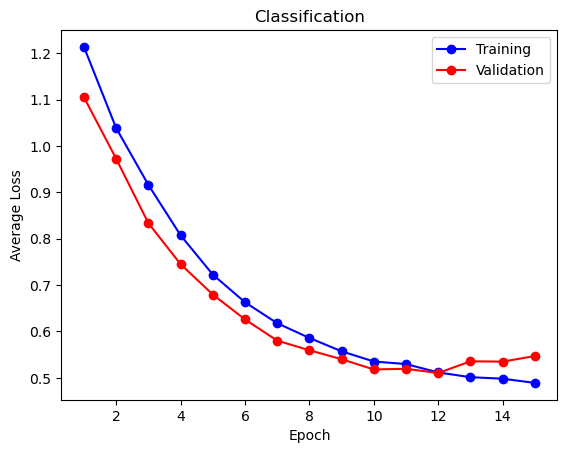

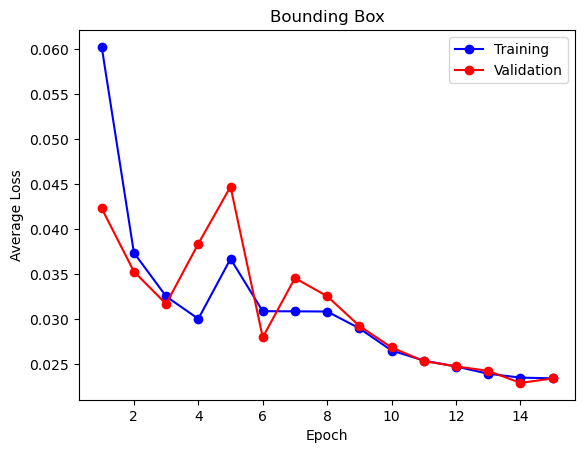

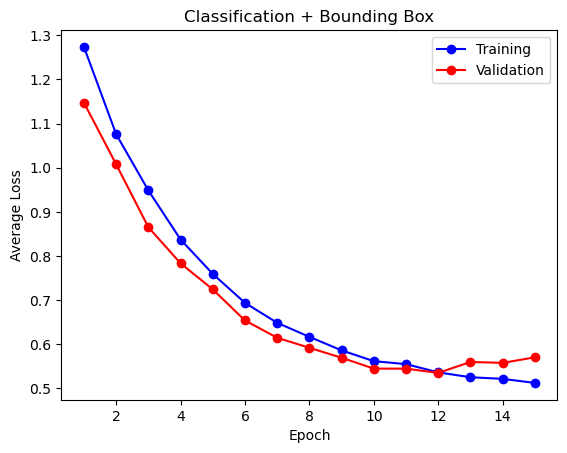

In [20]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 15, Learning Rate = 1e-3
model_15_1e_3 = RCNN().to(device)
optimizer = torch.optim.SGD(model_15_1e_3.parameters(), lr=1e-3)
epochs = 15
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_15_1e_3, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}".format(validation_losses[t][3]))
    print("Avg IOU: {:}\n", validation_losses[t][4])

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_15_1e_3.state_dict(), "./models/rcnn_15_1e_3_redo.pth")

Epoch 1
-------------------------------
Training:
Batch     0, classification loss: 1.607014, bbox loss: 0.587218, combined loss: 2.194232  [   32/23649]
Batch    50, classification loss: 1.667541, bbox loss: 0.368592, combined loss: 2.036133  [ 1632/23649]
Batch   100, classification loss: 1.626858, bbox loss: 0.606816, combined loss: 2.233675  [ 3232/23649]
Batch   150, classification loss: 1.640527, bbox loss: 0.460745, combined loss: 2.101271  [ 4832/23649]
Batch   200, classification loss: 1.617546, bbox loss: 0.440732, combined loss: 2.058278  [ 6432/23649]
Batch   250, classification loss: 1.610091, bbox loss: 0.580792, combined loss: 2.190883  [ 8032/23649]
Batch   300, classification loss: 1.623223, bbox loss: 0.518330, combined loss: 2.141553  [ 9632/23649]
Batch   350, classification loss: 1.592644, bbox loss: 0.521767, combined loss: 2.114411  [11232/23649]
Batch   400, classification loss: 1.625478, bbox loss: 0.350037, combined loss: 1.975515  [12832/23649]
Batch   450, c

Batch   250, classification loss: 1.587891, bbox loss: 0.076004, combined loss: 1.663895  [ 8032/23649]
Batch   300, classification loss: 1.612072, bbox loss: 0.083234, combined loss: 1.695306  [ 9632/23649]
Batch   350, classification loss: 1.575881, bbox loss: 0.150400, combined loss: 1.726280  [11232/23649]
Batch   400, classification loss: 1.574438, bbox loss: 0.104799, combined loss: 1.679237  [12832/23649]
Batch   450, classification loss: 1.563400, bbox loss: 0.080903, combined loss: 1.644303  [14432/23649]
Batch   500, classification loss: 1.538450, bbox loss: 0.090025, combined loss: 1.628475  [16032/23649]
Batch   550, classification loss: 1.516177, bbox loss: 0.068670, combined loss: 1.584847  [17632/23649]
Batch   600, classification loss: 1.552221, bbox loss: 0.061407, combined loss: 1.613627  [19232/23649]
Batch   650, classification loss: 1.549451, bbox loss: 0.065821, combined loss: 1.615272  [20832/23649]
Batch   700, classification loss: 1.555105, bbox loss: 0.096493,

Batch   550, classification loss: 1.567315, bbox loss: 0.077678, combined loss: 1.644993  [17632/23649]
Batch   600, classification loss: 1.456002, bbox loss: 0.069453, combined loss: 1.525455  [19232/23649]
Batch   650, classification loss: 1.517272, bbox loss: 0.045566, combined loss: 1.562838  [20832/23649]
Batch   700, classification loss: 1.479989, bbox loss: 0.073746, combined loss: 1.553735  [22432/23649]
Avg Training Error:
	 Classification: 1.517065387803155, Bounding Box: 0.05778749708740695, Combined: 1.5748528841379525
Avg Validation Error:
	 Classification: 1.5259596981815786, Bounding Box: 0.05666282794870145, Combined: 1.5826225247463035
Avg Positive Detection Accuracy: 0.5506358926048045

Epoch 10
-------------------------------
Training:
Batch     0, classification loss: 1.478933, bbox loss: 0.057445, combined loss: 1.536378  [   32/23649]
Batch    50, classification loss: 1.505908, bbox loss: 0.068067, combined loss: 1.573975  [ 1632/23649]
Batch   100, classification

Batch     0, classification loss: 1.436249, bbox loss: 0.069791, combined loss: 1.506040  [   32/23649]
Batch    50, classification loss: 1.433755, bbox loss: 0.065232, combined loss: 1.498986  [ 1632/23649]
Batch   100, classification loss: 1.458236, bbox loss: 0.040463, combined loss: 1.498700  [ 3232/23649]
Batch   150, classification loss: 1.500230, bbox loss: 0.038273, combined loss: 1.538503  [ 4832/23649]
Batch   200, classification loss: 1.467254, bbox loss: 0.054957, combined loss: 1.522211  [ 6432/23649]
Batch   250, classification loss: 1.537019, bbox loss: 0.052471, combined loss: 1.589490  [ 8032/23649]
Batch   300, classification loss: 1.543108, bbox loss: 0.045093, combined loss: 1.588201  [ 9632/23649]
Batch   350, classification loss: 1.466566, bbox loss: 0.047308, combined loss: 1.513874  [11232/23649]
Batch   400, classification loss: 1.429356, bbox loss: 0.047433, combined loss: 1.476789  [12832/23649]
Batch   450, classification loss: 1.446934, bbox loss: 0.047988,

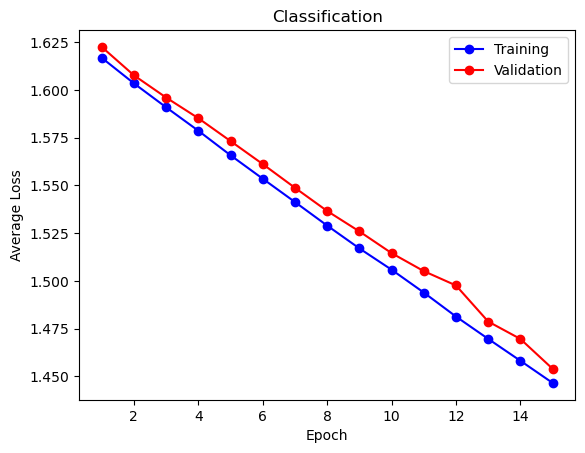

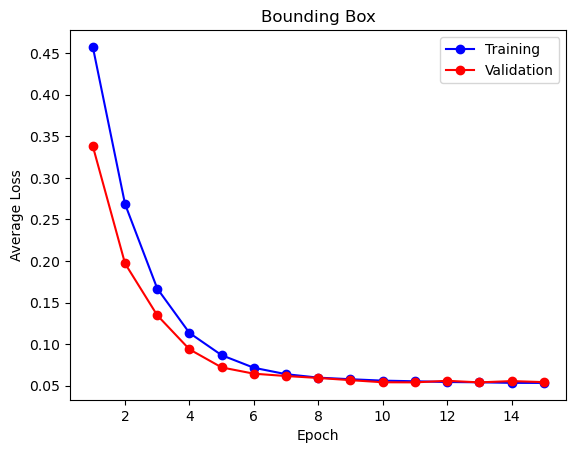

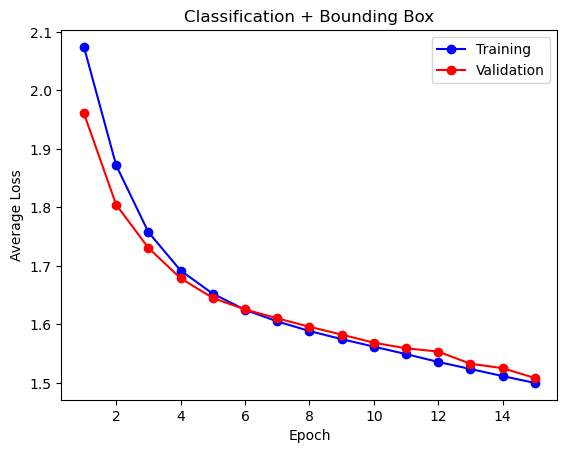

In [21]:
#Classification Block: 512 -> 128, 128 -> 64, 64 -> 5
#Bounding Box Regression Block -> 512 -> 64, 64 -> 16
#Epochs = 10, Learning Rate = 1e-5
model_15_1e_5 = RCNN().to(device)
optimizer = torch.optim.SGD(model_15_1e_5.parameters(), lr=1e-5)
epochs = 15
training_losses = []
validation_losses = []
confusion_matrix_training, confusion_matrix_validation = None, None
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    print("Training:")
    if t == epochs-1:
        results, confusion_matrix_training = train(training_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=True)
        training_losses.append(results)
    else:
        results, _ = train(training_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                             regression_loss_function, optimizer, hyper_lambda=1, confusion_matrix_bool=False)
        training_losses.append(results)
    print("Avg Training Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(training_losses[t][0],\
                                                 training_losses[t][1], training_losses[t][2]))
    if t == epochs-1:
        results, confusion_matrix_validation = validation(validation_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                                     regression_loss_function, hyper_lambda=1, confusion_matrix_bool=True)
        validation_losses.append(results)
    else:
        results, _ = validation(validation_loader, model_15_1e_5, nn.CrossEntropyLoss(),\
                                 regression_loss_function, hyper_lambda=1, confusion_matrix_bool=False)
        validation_losses.append(results)
    print("Avg Validation Error:\n\t Classification: {:}, Bounding Box: {:}, Combined: {:}".format(validation_losses[t][0],\
                                                 validation_losses[t][1], validation_losses[t][2]))
    print("Avg Positive Detection Accuracy: {:}\n".format(validation_losses[t][3]))

print("Training Confusion Matrix")
training_losses = np.array(training_losses)
print("Validation Confusion Matrix")
validation_losses = np.array(validation_losses)
print(confusion_matrix_training)
print(confusion_matrix_validation)

#plt.subplot(3, 1, 1)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[0]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[0]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification")
plt.show()

#plt.subplot(3, 1, 2)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[1]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[1]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Bounding Box")
plt.show()

#plt.subplot(3, 1, 3)
plt.plot(np.linspace(1, epochs, epochs), training_losses[:,[2]], marker='o', color='b', label="Training")
plt.plot(np.linspace(1, epochs, epochs), validation_losses[:,[2]], marker='o', color='r', label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Classification + Bounding Box")

#plt.tight_layout()
plt.show()

torch.save(model_15_1e_5.state_dict(), "./models/rcnn_15_1e_5_redo.pth")